# SpatioTemporal BLIS-Net Adaptation - METR-LA Dataset
Run the cells in this notebook to train and evaluate the STBLIS-Net. 
First, import the necessary libraries.

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import stblis_utils as stb
from stblis_classes import STBLISPrecompute, MLPNet
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

### Load the train, test, and val data
Shape is (num_samples, num_sensors, num_timesteps)

In [2]:
# Define the path to the compressed training data file
train_file_path = 'data/METR-LA/train.npz'

# Load the data for training
with np.load(train_file_path) as data:
    # Convert to float32 and permute dimensions (0, 2, 1, 3)
    x_train = torch.from_numpy(data['x']).permute(0, 2, 1, 3).to(torch.float32)
    y_train = torch.from_numpy(data['y']).permute(0, 2, 1, 3).to(torch.float32)  # Apply permute to y_train as well

x_train = x_train[..., 0]
y_train = y_train[..., 0]
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

# Define the path to the compressed test data file
test_file_path = 'data/METR-LA/test.npz'

# Load the data for testing
with np.load(test_file_path) as data:
    x_test = torch.from_numpy(data['x']).permute(0, 2, 1, 3).to(torch.float32)  # Permuting dimensions for x_test
    y_test = torch.from_numpy(data['y']).permute(0, 2, 1, 3).to(torch.float32)  # Apply permute to y_test as well

x_test= x_test[..., 0]
y_test = y_test[..., 0]
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

# Define the path to the compressed validation data file
val_file_path = 'data/METR-LA/val.npz'

# Load the data for validation
with np.load(val_file_path) as data:
    x_val = torch.from_numpy(data['x']).permute(0, 2, 1, 3).to(torch.float32)  # Permuting dimensions for x_val
    y_val = torch.from_numpy(data['y']).permute(0, 2, 1, 3).to(torch.float32)  # Apply permute to y_val as well

x_val = x_val[..., 0]
y_val = y_val[..., 0]
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)

x_train shape: torch.Size([23974, 207, 12])
y_train shape: torch.Size([23974, 207, 12])
x_test shape: torch.Size([6850, 207, 12])
y_test shape: torch.Size([6850, 207, 12])
x_val shape: torch.Size([3425, 207, 12])
y_val shape: torch.Size([3425, 207, 12])


### Load the adjacency matrix and create the time adjacency matrix. Create dictionaries for the mean and standard deviation values of each sensor, which can be used later to plot the original data.
Spatial adjacency matrix has shape (num_sensors, num_sensors).

Temporal adjacency matrix has shape (num_timesteps, num_timesteps).

In [3]:
# File paths
adj_file = 'adj_mx.pkl'
data_file = "data/METR-LA/metr-la.h5"

# Load adjacency matrix data from pickle file
with open(adj_file, 'rb') as f:
    sensor_ids, sensor_id_to_ind, adj_mx = pickle.load(f, encoding='latin1')

# Convert adjacency matrix to a tensor and set its dtype to float32
adj_mx = torch.from_numpy(adj_mx).to(torch.float32)
print(f"Spatial adjacency Matrix Shape: {adj_mx.shape}")

# Generate time adjacency matrix
tadj_mx = stb.get_time_adj(x_train.shape[2])
print(f"Temporal Adjacency Matrix Shape: {tadj_mx.shape}")

# Load dataset
df = pd.read_hdf(data_file)

# Compute mean and standard deviation for each sensor, store in dict
mean_values = df.mean().to_dict()
std_values = df.std().to_dict()

# Map mean and std values to the corresponding sensor indices
mean_ind_dict = {
    sensor_id_to_ind[sensor_id]: mean_values[sensor_id]
    for sensor_id in mean_values if sensor_id in sensor_id_to_ind
}

std_ind_dict = {
    sensor_id_to_ind[sensor_id]: std_values[sensor_id]
    for sensor_id in std_values if sensor_id in sensor_id_to_ind
}

Spatial adjacency Matrix Shape: torch.Size([207, 207])
Temporal Adjacency Matrix Shape: torch.Size([12, 12])


### Set model hyperparameters

In [4]:
# BLIS module parameters
# K specifies the number of spatial wavelet filters in the frame. Total spatial filters = K+2
# J specifies the number of temporal wavelet filters in the frame. Total temporal filters = J+2
K = 4
J = 2

# MLP Parameters
_, num_nodes, num_timesteps = x_train.shape
mlp_input_dim = num_nodes * num_timesteps
embedding_dim = int(mlp_input_dim / 4)
output_dim = 12

# Training parameters
batch_size = 64
num_epochs = 50
patience, trigger_times = 10, 0  # Patience of 10 epochs
learning_rate = 0.001
num_trainings = 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device detected: {device}")

Device detected: cuda


### Precompute STBLIS module
This does not need to be done over each training iteration because it is deterministic. Thus, we save the precomputed outputs for later.

In [5]:
# Instantiate model
blis_precomp = STBLISPrecompute(adj_mx, tadj_mx, K, J)

with torch.no_grad():
    print("Precomputing Train!")
    precomputed_train = blis_precomp(x_train)
    print("Precomputing Val!")
    precomputed_val = blis_precomp(x_val)
    print("Precomputing Test!")
    precomputed_test = blis_precomp(x_test)

# Save precomputed tensors
torch.save(precomputed_train, 'precomputed_train.pt')
torch.save(precomputed_val, 'precomputed_val.pt')
torch.save(precomputed_test, 'precomputed_test.pt')

Precomputing Train!
Precomputing Val!
Precomputing Test!


### Load precomputed data

In [6]:
precomputed_train = torch.load('precomputed_train.pt')
precomputed_val = torch.load('precomputed_val.pt')
precomputed_test = torch.load('precomputed_test.pt')

# Create new DataLoaders for precomputed data
precomputed_train_loader = DataLoader(TensorDataset(precomputed_train, y_train), batch_size=batch_size, shuffle=True)
precomputed_val_loader = DataLoader(TensorDataset(precomputed_val, y_val), batch_size=batch_size, shuffle=False)
precomputed_test_loader = DataLoader(TensorDataset(precomputed_test, y_test), batch_size=batch_size, shuffle=False)

### Train the model multiple times

In [7]:
for train_iter in range(num_trainings):
    print(f"\n\nTRAINING MODEL {train_iter+1}\n\n")
        
    # Define model save name
    model_save_name = f'best_STBLIS_model_{train_iter+1}.pth'
    
    # Define a new model for each training iteration
    mlp_model = MLPNet(mlp_input_dim, embedding_dim, output_dim, num_nodes, device).to(device)
                                                                                      
    # Wrap model with DataParallel to utilize all GPU resources
    if torch.cuda.device_count() > 1:
        mlp_model = nn.DataParallel(mlp_model)
    
    # Defien loss function and optimizer
    criterion = nn.L1Loss()
    optimizer = optim.Adam(mlp_model.parameters(), lr=learning_rate)
    
    best_val_loss = float('inf')
    
    # Training loop
    for epoch in range(num_epochs):
        mlp_model.train()
        train_loss = 0.0
        
        for x_batch, y_batch in tqdm(precomputed_train_loader, desc=f"Train Epoch {epoch + 1}"):
            x_b, y_b = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            # Pad batch with zeros on last batch
            A, B, C = x_b.shape
            if A != batch_size:
                x_b = stb.pad_tensor(x_b, batch_size)
                y_b = stb.pad_tensor(y_b, batch_size)
                A, B, C = x_b.shape
                        
            x_b = x_b.reshape(A, B*C)
            
            output = mlp_model(x_b)
            loss = criterion(output, y_b)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x_b.size(0)
        
        train_loss /= len(precomputed_train_loader.dataset)
    
        # Validation loop
        mlp_model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x_val_batch, y_val_batch in tqdm(precomputed_val_loader, desc=f"Validation Epoch {epoch + 1}"):
                x_b, y_b = x_val_batch.to(device), y_val_batch.to(device)

                # Pad batch with zeros on last batch
                A, B, C = x_b.shape
                if A != batch_size:
                    x_b = stb.pad_tensor(x_b, batch_size)
                    y_b = stb.pad_tensor(y_b, batch_size)
                    A, B, C = x_b.shape
                    
                x_b = x_b.reshape(A, B*C)
                
                output = mlp_model(x_b)
                loss = criterion(output, y_b)
                val_loss += loss.item() * x_b.size(0)
        
        val_loss /= len(precomputed_val_loader.dataset)
    
        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            trigger_times = 0
            torch.save(mlp_model.state_dict(), model_save_name)
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print(f'Model {train_iter+1}: Early stopping!')
                break
    
        print(f'Model {train_iter+1}: Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')



TRAINING MODEL 1




Validation Epoch 1: 100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 300.45it/s]


Model 1: Epoch 1/50, Train Loss: 0.4223, Validation Loss: 0.3331


Validation Epoch 2: 100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 301.24it/s]


Model 1: Epoch 2/50, Train Loss: 0.3543, Validation Loss: 0.3231


Validation Epoch 3: 100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 298.49it/s]


Model 1: Epoch 3/50, Train Loss: 0.3404, Validation Loss: 0.2998


Validation Epoch 4: 100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 306.17it/s]


Model 1: Epoch 4/50, Train Loss: 0.3298, Validation Loss: 0.2956


Validation Epoch 5: 100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 306.62it/s]


Model 1: Epoch 5/50, Train Loss: 0.3243, Validation Loss: 0.2938


Validation Epoch 6: 100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 301.61it/s]


Model 1: Epoch 6/50, Train Loss: 0.3197, Validation Loss: 0.2877


Validation Epoch 7: 100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 298.95it/s]


Model 1: Epoch 7/50, Train Loss: 0.3173, Validation Loss: 0.2933


Validation Epoch 8: 100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 299.80it/s]


Model 1: Epoch 8/50, Train Loss: 0.3127, Validation Loss: 0.2867


Validation Epoch 9: 100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 301.35it/s]


Model 1: Epoch 9/50, Train Loss: 0.3134, Validation Loss: 0.2847


Validation Epoch 10: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 297.26it/s]


Model 1: Epoch 10/50, Train Loss: 0.3106, Validation Loss: 0.3097


Validation Epoch 11: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 304.07it/s]


Model 1: Epoch 11/50, Train Loss: 0.3069, Validation Loss: 0.2962


Validation Epoch 12: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 300.88it/s]


Model 1: Epoch 12/50, Train Loss: 0.3067, Validation Loss: 0.2771


Validation Epoch 13: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 304.77it/s]


Model 1: Epoch 13/50, Train Loss: 0.3041, Validation Loss: 0.2890


Validation Epoch 14: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 293.91it/s]


Model 1: Epoch 14/50, Train Loss: 0.3018, Validation Loss: 0.2868


Validation Epoch 15: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 291.92it/s]


Model 1: Epoch 15/50, Train Loss: 0.3021, Validation Loss: 0.2740


Validation Epoch 16: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 295.46it/s]


Model 1: Epoch 16/50, Train Loss: 0.3026, Validation Loss: 0.2885


Validation Epoch 17: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 297.37it/s]


Model 1: Epoch 17/50, Train Loss: 0.3000, Validation Loss: 0.3084


Validation Epoch 18: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 300.37it/s]


Model 1: Epoch 18/50, Train Loss: 0.3005, Validation Loss: 0.2707


Validation Epoch 19: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 300.42it/s]


Model 1: Epoch 19/50, Train Loss: 0.3007, Validation Loss: 0.2820


Validation Epoch 20: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 301.11it/s]


Model 1: Epoch 20/50, Train Loss: 0.2979, Validation Loss: 0.2763


Validation Epoch 21: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 301.65it/s]


Model 1: Epoch 21/50, Train Loss: 0.2964, Validation Loss: 0.2893


Validation Epoch 22: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 295.93it/s]


Model 1: Epoch 22/50, Train Loss: 0.2952, Validation Loss: 0.2894


Validation Epoch 23: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 301.57it/s]


Model 1: Epoch 23/50, Train Loss: 0.2957, Validation Loss: 0.2987


Validation Epoch 24: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 305.46it/s]


Model 1: Epoch 24/50, Train Loss: 0.2947, Validation Loss: 0.2782


Validation Epoch 25: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 302.90it/s]


Model 1: Epoch 25/50, Train Loss: 0.2937, Validation Loss: 0.2937


Validation Epoch 26: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 304.34it/s]


Model 1: Epoch 26/50, Train Loss: 0.2920, Validation Loss: 0.2707


Validation Epoch 27: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 299.83it/s]


Model 1: Epoch 27/50, Train Loss: 0.2938, Validation Loss: 0.2789


Validation Epoch 28: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 303.03it/s]


Model 1: Epoch 28/50, Train Loss: 0.2924, Validation Loss: 0.2806


Validation Epoch 29: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 302.87it/s]


Model 1: Epoch 29/50, Train Loss: 0.2908, Validation Loss: 0.2748


Validation Epoch 30: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 302.33it/s]


Model 1: Epoch 30/50, Train Loss: 0.2912, Validation Loss: 0.2754


Validation Epoch 31: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 298.85it/s]


Model 1: Epoch 31/50, Train Loss: 0.2889, Validation Loss: 0.2716


Validation Epoch 32: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 305.24it/s]


Model 1: Epoch 32/50, Train Loss: 0.2883, Validation Loss: 0.2833


Validation Epoch 33: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 302.92it/s]


Model 1: Epoch 33/50, Train Loss: 0.2892, Validation Loss: 0.2830


Validation Epoch 34: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 300.65it/s]


Model 1: Epoch 34/50, Train Loss: 0.2880, Validation Loss: 0.2745


Validation Epoch 35: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 298.25it/s]


Model 1: Epoch 35/50, Train Loss: 0.2874, Validation Loss: 0.2707


Validation Epoch 36: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 299.56it/s]


Model 1: Early stopping!


TRAINING MODEL 2




Validation Epoch 1: 100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 299.98it/s]


Model 2: Epoch 1/50, Train Loss: 0.4225, Validation Loss: 0.3195


Validation Epoch 2: 100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 305.29it/s]


Model 2: Epoch 2/50, Train Loss: 0.3534, Validation Loss: 0.3085


Validation Epoch 3: 100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 300.41it/s]


Model 2: Epoch 3/50, Train Loss: 0.3409, Validation Loss: 0.3050


Validation Epoch 4: 100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 298.57it/s]


Model 2: Epoch 4/50, Train Loss: 0.3307, Validation Loss: 0.2924


Validation Epoch 5: 100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 298.96it/s]


Model 2: Epoch 5/50, Train Loss: 0.3258, Validation Loss: 0.2964


Validation Epoch 6: 100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 290.50it/s]


Model 2: Epoch 6/50, Train Loss: 0.3231, Validation Loss: 0.3035


Validation Epoch 7: 100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 295.48it/s]


Model 2: Epoch 7/50, Train Loss: 0.3182, Validation Loss: 0.3011


Validation Epoch 8: 100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 291.85it/s]


Model 2: Epoch 8/50, Train Loss: 0.3142, Validation Loss: 0.2860


Validation Epoch 9: 100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 293.39it/s]


Model 2: Epoch 9/50, Train Loss: 0.3118, Validation Loss: 0.2843


Validation Epoch 10: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 293.21it/s]


Model 2: Epoch 10/50, Train Loss: 0.3098, Validation Loss: 0.3039


Validation Epoch 11: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 279.62it/s]


Model 2: Epoch 11/50, Train Loss: 0.3073, Validation Loss: 0.2821


Validation Epoch 12: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 298.96it/s]


Model 2: Epoch 12/50, Train Loss: 0.3067, Validation Loss: 0.2779


Validation Epoch 13: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 303.51it/s]


Model 2: Epoch 13/50, Train Loss: 0.3054, Validation Loss: 0.2870


Validation Epoch 14: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 306.84it/s]


Model 2: Epoch 14/50, Train Loss: 0.3062, Validation Loss: 0.2970


Validation Epoch 15: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 301.21it/s]


Model 2: Epoch 15/50, Train Loss: 0.3042, Validation Loss: 0.2741


Validation Epoch 16: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 300.39it/s]


Model 2: Epoch 16/50, Train Loss: 0.3020, Validation Loss: 0.2869


Validation Epoch 17: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 297.21it/s]


Model 2: Epoch 17/50, Train Loss: 0.2991, Validation Loss: 0.2696


Validation Epoch 18: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 301.92it/s]


Model 2: Epoch 18/50, Train Loss: 0.2992, Validation Loss: 0.3069


Validation Epoch 19: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 299.08it/s]


Model 2: Epoch 19/50, Train Loss: 0.2997, Validation Loss: 0.2823


Validation Epoch 20: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 303.68it/s]


Model 2: Epoch 20/50, Train Loss: 0.2977, Validation Loss: 0.2863


Validation Epoch 21: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 300.87it/s]


Model 2: Epoch 21/50, Train Loss: 0.2946, Validation Loss: 0.2822


Validation Epoch 22: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 301.17it/s]


Model 2: Epoch 22/50, Train Loss: 0.2954, Validation Loss: 0.2726


Validation Epoch 23: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 296.84it/s]


Model 2: Epoch 23/50, Train Loss: 0.2961, Validation Loss: 0.2758


Validation Epoch 24: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 299.32it/s]


Model 2: Epoch 24/50, Train Loss: 0.2941, Validation Loss: 0.3220


Validation Epoch 25: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 300.57it/s]


Model 2: Epoch 25/50, Train Loss: 0.2928, Validation Loss: 0.2740


Validation Epoch 26: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 299.09it/s]


Model 2: Epoch 26/50, Train Loss: 0.2913, Validation Loss: 0.2947


Validation Epoch 27: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 297.34it/s]


Model 2: Early stopping!


TRAINING MODEL 3




Validation Epoch 1: 100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 301.72it/s]


Model 3: Epoch 1/50, Train Loss: 0.4228, Validation Loss: 0.3204


Validation Epoch 2: 100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 300.53it/s]


Model 3: Epoch 2/50, Train Loss: 0.3591, Validation Loss: 0.3151


Validation Epoch 3: 100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 301.01it/s]


Model 3: Epoch 3/50, Train Loss: 0.3398, Validation Loss: 0.3105


Validation Epoch 4: 100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 298.03it/s]


Model 3: Epoch 4/50, Train Loss: 0.3305, Validation Loss: 0.3424


Validation Epoch 5: 100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 294.63it/s]


Model 3: Epoch 5/50, Train Loss: 0.3247, Validation Loss: 0.3034


Validation Epoch 6: 100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 300.13it/s]


Model 3: Epoch 6/50, Train Loss: 0.3218, Validation Loss: 0.2906


Validation Epoch 7: 100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 296.82it/s]


Model 3: Epoch 7/50, Train Loss: 0.3157, Validation Loss: 0.2883


Validation Epoch 8: 100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 297.61it/s]


Model 3: Epoch 8/50, Train Loss: 0.3154, Validation Loss: 0.2914


Validation Epoch 9: 100%|██████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 299.22it/s]


Model 3: Epoch 9/50, Train Loss: 0.3114, Validation Loss: 0.2868


Validation Epoch 10: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 296.34it/s]


Model 3: Epoch 10/50, Train Loss: 0.3071, Validation Loss: 0.3076


Validation Epoch 11: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 297.72it/s]


Model 3: Epoch 11/50, Train Loss: 0.3076, Validation Loss: 0.3130


Validation Epoch 12: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 298.06it/s]


Model 3: Epoch 12/50, Train Loss: 0.3056, Validation Loss: 0.3259


Validation Epoch 13: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 297.52it/s]


Model 3: Epoch 13/50, Train Loss: 0.3063, Validation Loss: 0.2844


Validation Epoch 14: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 300.53it/s]


Model 3: Epoch 14/50, Train Loss: 0.3033, Validation Loss: 0.2914


Validation Epoch 15: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 299.56it/s]


Model 3: Epoch 15/50, Train Loss: 0.3041, Validation Loss: 0.2753


Validation Epoch 16: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 299.30it/s]


Model 3: Epoch 16/50, Train Loss: 0.3024, Validation Loss: 0.3027


Validation Epoch 17: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 289.98it/s]


Model 3: Epoch 17/50, Train Loss: 0.3003, Validation Loss: 0.3044


Validation Epoch 18: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 288.44it/s]


Model 3: Epoch 18/50, Train Loss: 0.2981, Validation Loss: 0.2989


Validation Epoch 19: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 291.50it/s]


Model 3: Epoch 19/50, Train Loss: 0.2973, Validation Loss: 0.2862


Validation Epoch 20: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 286.54it/s]


Model 3: Epoch 20/50, Train Loss: 0.2959, Validation Loss: 0.2877


Validation Epoch 21: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 298.12it/s]


Model 3: Epoch 21/50, Train Loss: 0.2957, Validation Loss: 0.2910


Validation Epoch 22: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 305.71it/s]


Model 3: Epoch 22/50, Train Loss: 0.2963, Validation Loss: 0.2829


Validation Epoch 23: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 307.71it/s]


Model 3: Epoch 23/50, Train Loss: 0.2959, Validation Loss: 0.3213


Validation Epoch 24: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 301.68it/s]


Model 3: Epoch 24/50, Train Loss: 0.2927, Validation Loss: 0.2840


Validation Epoch 25: 100%|█████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 300.93it/s]

Model 3: Early stopping!


### Evaluate the trained models
We will generate the predicted outputs and store them in a dictionary, allowing us to plot them later

In [7]:
model_preds_dict = {}
model_actuals_dict = {}
for test_iter in range(num_trainings):

    # Load model for testing
    model_save_name = f'best_STBLIS_model_{test_iter+1}.pth'
    
    # Load the trained model's state dictionary
    state_dict = torch.load(model_save_name)
    
    # Remove 'module.' prefix if present
    state_dict = stb.remove_module_prefix(state_dict)

    # Load model parameters
    mlp_model = MLPNet(mlp_input_dim, embedding_dim, output_dim, num_nodes, device).to(device)
    mlp_model.load_state_dict(state_dict)
    
    # Define loss function and optimizer
    criterion = nn.L1Loss()
    optimizer = optim.Adam(mlp_model.parameters(), lr=learning_rate)
    
    # Testing loop
    mlp_model.eval()
    test_loss = 0.0

    all_test_preds = []
    all_test_actuals = []
    with torch.no_grad():
        for x_batch, y_batch in tqdm(precomputed_test_loader, desc=f"Evaluating on Test Data"):
            x_b, y_b = x_batch.to(device), y_batch.to(device)

            # Pad batch_size on last batch so that it is the same as the other batch sizes
            A, B, C = x_b.shape
            if A != batch_size:
                x_b = stb.pad_tensor(x_b, batch_size)
                y_b = stb.pad_tensor(y_b, batch_size)
                A, B, C = x_b.shape
        
            x_b = x_b.reshape(A, B*C)
            
            output = mlp_model(x_b)
            loss = criterion(output, y_b)
            test_loss += loss.item() * x_b.size(0)
            all_test_preds.append(output.cpu())
            all_test_actuals.append(y_b.cpu())
    
    all_test_preds = torch.cat(all_test_preds, dim=0)
    all_test_actuals = torch.cat(all_test_actuals, dim=0)
    
    test_loss /= len(precomputed_test_loader.dataset)
    print(f'Model {test_iter+1}: Test Loss: {test_loss:.4f}')

    # Save predictions and actuals in a dictionary for easy access later
    model_preds_dict[test_iter+1] = all_test_preds
    model_actuals_dict[test_iter+1] = all_test_actuals

Evaluating on Test Data: 100%|███████████████████████████████████████████████████████| 108/108 [00:00<00:00, 149.85it/s]


Model 1: Test Loss: 0.3329


Evaluating on Test Data: 100%|██████████████████████████████████████████████████████| 108/108 [00:00<00:00, 1026.40it/s]


Model 2: Test Loss: 0.3290


Evaluating on Test Data: 100%|██████████████████████████████████████████████████████| 108/108 [00:00<00:00, 1005.15it/s]

Model 3: Test Loss: 0.3316


### Generate sample plots of the predicted outputs

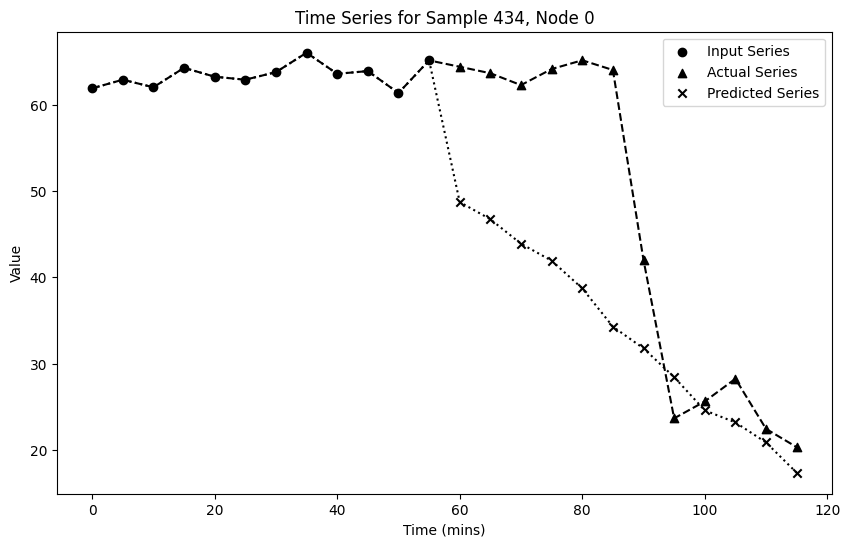

In [11]:
model_num = 1 # Specify the model you want to plot. This is 1-indexed
sample_index = 434  # Specify the sample index you want to plot
node_index = 0 # Specify the node index you want to plot
model_test_preds = model_preds_dict[model_num]
model_test_actuals = model_actuals_dict[model_num]

# Call helper function to plot the predicted vs actual output
stb.plot_time_series(sample_index, node_index, x_test, model_test_actuals, model_test_preds, num_timesteps, num_nodes, output_dim, mean_ind_dict, std_ind_dict, zscore=False)

### Calculate metrics for model evaluation

In [10]:
# Initialize empty dictionaries to hold the sum of metrics and squared sum for std calculation
# Index 2 is 15 mins, index 5 is 30 mins, index 11 is 60 mins (each index is a 5 min interval)
avg_metrics = {}
std_metrics = {}
indices = [2, 5, 11]

# Initialize the dictionaries to accumulate metrics and squared metrics for each index
for idx in indices:
    avg_metrics[idx] = {'MAE': 0, 'RMSE': 0, 'MAPE': 0}
    std_metrics[idx] = {'MAE': 0, 'RMSE': 0, 'MAPE': 0}

# Loop over each training/trial
for model_num in range(num_trainings):
    model_test_preds = model_preds_dict[model_num + 1]
    model_test_actuals = model_actuals_dict[model_num + 1]
    
    # Get metrics for this trial
    metrics = stb.calculate_metrics_per_index(model_test_preds, model_test_actuals, indices)
    
    # Accumulate the metrics and squared metrics for averaging and std calculation
    for idx in metrics:
        for metric in metrics[idx]:
            avg_metrics[idx][metric] += metrics[idx][metric]
            std_metrics[idx][metric] += metrics[idx][metric] ** 2

# Calculate the average and std across all trials
for idx in avg_metrics:
    for metric in avg_metrics[idx]:
        avg_metrics[idx][metric] /= num_trainings
        std_metrics[idx][metric] = np.sqrt(std_metrics[idx][metric] / num_trainings - avg_metrics[idx][metric] ** 2)

# Print the averaged and std metrics for each index
print(f"Average metrics over {num_trainings} training samples:")
for idx in avg_metrics:
    print(f"Time Prediction {(idx + 1) * 5} mins: "
          f"Avg MAE: {avg_metrics[idx]['MAE']:.4f}, "
          f"Avg RMSE: {avg_metrics[idx]['RMSE']:.4f}, "
          f"Avg MAPE: {avg_metrics[idx]['MAPE']:.4f}, "
          f"Std MAE: {std_metrics[idx]['MAE']:.4f}, "
          f"Std RMSE: {std_metrics[idx]['RMSE']:.4f}, "
          f"Std MAPE: {std_metrics[idx]['MAPE']:.4f}")


Average metrics over 3 training samples:
Time Prediction 15 mins: Avg MAE: 0.2868, Avg RMSE: 0.6167, Avg MAPE: 1.6158, Std MAE: 0.0016, Std RMSE: 0.0030, Std MAPE: 0.0267
Time Prediction 30 mins: Avg MAE: 0.3256, Avg RMSE: 0.7028, Avg MAPE: 1.8097, Std MAE: 0.0027, Std RMSE: 0.0021, Std MAPE: 0.0340
Time Prediction 60 mins: Avg MAE: 0.3871, Avg RMSE: 0.8095, Avg MAPE: 1.9148, Std MAE: 0.0014, Std RMSE: 0.0012, Std MAPE: 0.0379
